In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import climlab
from climlab.radiation import RRTMG
from scipy import interpolate
from scipy.interpolate import griddata
import cartopy.crs as ccrs

In [2]:
#from lecture
#sets up the Slab Ocean Model and Coupled Model
casenames = {'cpl_control': 'cpl_1850_f19',
             'cpl_CO2ramp': 'cpl_CO2ramp_f19',
             'som_control': 'som_1850_f19',
             'som_2xCO2':   'som_1850_2xCO2',
            }

basepath = '/roselab_rit/cesm_archive/'
#basepath = 'http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/' 

casepaths = {}
for name in casenames:
    casepaths[name] = basepath + casenames[name] + '/concatenated/'   
    
atm = {}
for name in casenames:
    path = casepaths[name] + casenames[name] + '.cam.h0.nc'
    print('Attempting to open the dataset ', path)
    atm[name] = xr.open_dataset(path, decode_times=False)

Attempting to open the dataset  /roselab_rit/cesm_archive/cpl_1850_f19/concatenated/cpl_1850_f19.cam.h0.nc
Attempting to open the dataset  /roselab_rit/cesm_archive/cpl_CO2ramp_f19/concatenated/cpl_CO2ramp_f19.cam.h0.nc
Attempting to open the dataset  /roselab_rit/cesm_archive/som_1850_f19/concatenated/som_1850_f19.cam.h0.nc
Attempting to open the dataset  /roselab_rit/cesm_archive/som_1850_2xCO2/concatenated/som_1850_2xCO2.cam.h0.nc


In [3]:
#scaling variables for cesm models
som_q_control = atm['som_control'].Q.isel(time=slice(-(10*12+1),-1)).mean(dim='time')

mlon = som_q_control.lon
mlat = som_q_control.lat
mlev = som_q_control.lev

#weighting factor for averaging over vertical axis
lw = np.log(mlev)
mw = np.cos(np.deg2rad(mlat))

# Kernels

In [4]:
###CAM3 kernels###
#sw albedo kernels (3D)
albedo_sw_clr_d = xr.open_dataset('Data/CAM3_albedo_sw_clr_kernel.nc') #clr means clear sky
albedo_sw_d = xr.open_dataset('Data/CAM3_albedo_sw_kernel.nc') #all-sky

#temp profile kernels (4D)
planck_lw_clr_d = xr.open_dataset('Data/CAM3_planck_lw_clr_kernel.nc')
planck_lw_d = xr.open_dataset('Data/CAM3_planck_lw_kernel.nc')

#surface temp kernels (3D)
surft_lw_clr_d = xr.open_dataset('Data/CAM3_surft_lw_clr_kernel.nc')
surft_lw_d = xr.open_dataset('Data/CAM3_surft_lw_kernel.nc')

#water vapor kernels (4D)
wv_lw_clr_d = xr.open_dataset('Data/CAM3_wv_lw_clr_kernel.nc')
wv_lw_d = xr.open_dataset('Data/CAM3_wv_lw_kernel.nc')
wv_sw_clr_d = xr.open_dataset('Data/CAM3_wv_sw_clr_kernel.nc')
wv_sw_d = xr.open_dataset('Data/CAM3_wv_sw_kernel.nc')

#help(surft_lw_clr_d)

#scaling variables for kernels
#print(surft_lw_d.attrs)
lat = albedo_sw_clr_d.lat[:]
lon = albedo_sw_clr_d.lon[:]
lev = wv_lw_clr_d.lev[:]
w = np.cos(np.deg2rad(lat))
klw = np.log(lev)

In [5]:
#from Brian Rose
def interp(lat1, lev1, data, lat2, lev2):
    '''A general purpose interpolation routine for transforming
    between two different latitude - pressure level grids.'''
    nlat = lat2.size
    nlev = lev2.size
    X1, Y1 = np.meshgrid(lat1, lev1)
    X2, Y2 = np.meshgrid(lat2, lev2)
    #print('X1: ',X1)
    #print('X2: ',X2)
    points_in = np.transpose(np.array([X1.flatten(), Y1.flatten()]))
    #print('in: ',points_in)
    points_out = np.transpose(np.array([X2.flatten(), Y2.flatten()]))
    #print('out: ',points_out)
    data_interp = griddata(points_in, data.flatten(),points_out, method='linear').reshape(nlev, nlat)
    return data_interp



In [6]:
#from lecture
gw = atm['som_control'].gw
def globalMean(field, weight=gw):
    '''Return the area-weighted global average of the input field'''
    return (field*weight).mean(dim=('lat','lon'))/weight.mean(dim='lat')

def maskGlobalMean(d,w):
    "computes global mean of the regridded data (lat,lon). It deals with nans contained within an array"
    md = np.ma.masked_array(d, np.isnan(d))
    test = np.ma.average(np.ma.average(md,axis=0,weights = w))
    return test

def globalMeanInterp(d,w,lw):
    "computes global mean of the regridded data (lev,lat). It deals with nans contained within an array"
    md = np.ma.masked_array(d, np.isnan(d))
    test = np.ma.average(np.ma.average(md,axis=1,weights = w),weights=lw)
    return test

#plt.contourf(mlat,wv_lw_d.lev,test,cmap="seismic",vmin=-0.35,vmax=0.35)
#plt.colorbar()
#plt.gca().invert_yaxis()

In [7]:
#From lecture
def make_map(field,label):
    '''input field should be a 2D xarray.DataArray on a lat/lon grid.
        Make a filled contour plot of the field, and a line plot of the zonal mean
    '''
    fig = plt.figure(figsize=(14,6))
    nrows = 10; ncols = 3
    mapax = plt.subplot2grid((nrows,ncols), (0,0), colspan=ncols-1, rowspan=nrows-1, projection=ccrs.Robinson())
    barax = plt.subplot2grid((nrows,ncols), (nrows-1,0), colspan=ncols-1)
    plotax = plt.subplot2grid((nrows,ncols), (0,ncols-1), rowspan=nrows-1)
    cx = mapax.contourf(field.lon, field.lat, field, transform=ccrs.PlateCarree())
    mapax.set_global(); mapax.coastlines();
    plt.colorbar(cx, cax=barax, orientation='horizontal',label=label)
    plotax.plot(field.mean(dim='lon'), field.lat)
    plotax.set_ylabel('Latitude')
    plotax.grid()
    return fig, (mapax, plotax, barax), cx

In [8]:
#converts kernels to arrays
albedo_sw_clr = xr.open_dataset('Data/CAM3_albedo_sw_clr_kernel.nc').to_array()[0]
albedo_sw = xr.open_dataset('Data/CAM3_albedo_sw_kernel.nc').to_array()[0]
planck_lw_clr = xr.open_dataset('Data/CAM3_planck_lw_clr_kernel.nc').to_array()[0]
planck_lw = xr.open_dataset('Data/CAM3_planck_lw_kernel.nc').to_array()[0]
surft_lw_clr = xr.open_dataset('Data/CAM3_surft_lw_clr_kernel.nc').to_array()[0]
surft_lw = xr.open_dataset('Data/CAM3_surft_lw_kernel.nc').to_array()[0]
wv_lw_clr = xr.open_dataset('Data/CAM3_wv_lw_clr_kernel.nc').to_array()[0]
wv_lw = xr.open_dataset('Data/CAM3_wv_lw_kernel.nc').to_array()[0]
wv_sw_clr = xr.open_dataset('Data/CAM3_wv_sw_clr_kernel.nc').to_array()[0]
wv_sw = xr.open_dataset('Data/CAM3_wv_sw_kernel.nc').to_array()[0]

In [9]:
#kernel annual average
an_albedo_sw = np.average(albedo_sw,axis=0) #64x128
an_albedo_sw_clr = np.average(albedo_sw_clr,axis=0) #64x128
an_planck_lw = np.average(planck_lw,axis=0) #17x64x128
an_planck_lw_clr = np.average(planck_lw_clr,axis=0) #17x64x128
an_surft_lw = np.average(surft_lw,axis=0) #64x128
an_surft_lw_clr = np.average(surft_lw_clr,axis=0) #64x128
an_wv_lw = np.average(wv_lw,axis=0) #17x64x128
an_wv_lw_clr = np.average(wv_lw_clr,axis=0) #17x64x128
an_wv_sw = np.average(wv_sw,axis=0) #17x64x128
an_wv_sw_clr = np.average(wv_sw_clr,axis=0) #17x64x128

In [10]:
#regridding of 2d kernels (after time average) to (lat,lon)
i_a_sw = interp(lon,lat,an_albedo_sw,mlon,mlat)
i_a_sw_clr = interp(lon,lat,an_albedo_sw_clr,mlon,mlat)
i_st_lw = interp(lon,lat,an_surft_lw,mlon,mlat)
i_st_lw_clr = interp(lon,lat,an_surft_lw_clr,mlon,mlat)

In [11]:
#regridding the 3D data (after time average)
#regrids to (lev,lat)
p_lw = np.average(an_planck_lw,axis=2)
pc_lw = np.average(an_planck_lw_clr,axis=2)
wv_lw = np.average(an_wv_lw,axis=2)
wvc_lw = np.average(an_wv_lw_clr,axis=2)
wv_sw = np.average(an_wv_sw,axis=2)
wvc_sw = np.average(an_wv_sw_clr,axis=2)

plat_p_lw = interp(lat,lev,p_lw,mlat,mlev)
plat_p_lw_clr = interp(lat,lev,pc_lw,mlat,mlev)
plat_wv_lw = interp(lat,lev,wv_lw,mlat,mlev)
plat_wv_lw_clr = interp(lat,lev,wvc_lw,mlat,mlev)
plat_wv_sw = interp(lat,lev,wv_sw,mlat,mlev)
plat_wv_sw_clr = interp(lat,lev,wvc_sw,mlat,mlev)

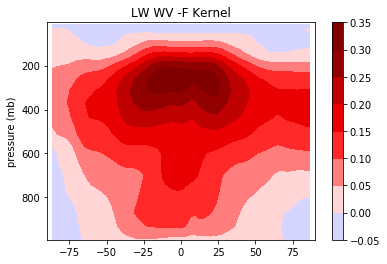

In [12]:
plt.contourf(mlat,mlev,-plat_wv_lw,cmap = 'seismic', vmax = 0.3, vmin = -0.3)
plt.gca().invert_yaxis()
plt.ylabel('pressure (mb)')
plt.title('LW WV -F Kernel' )
plt.colorbar()

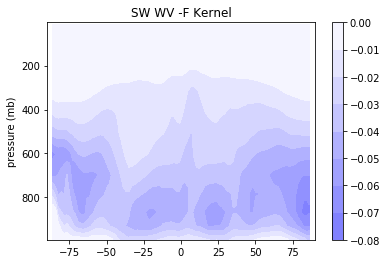

In [13]:
plt.contourf(mlat,mlev,-plat_wv_sw,cmap = 'seismic', vmax = 0.3, vmin = -0.3)
plt.gca().invert_yaxis()
plt.ylabel('pressure (mb)')
plt.title('SW WV -F Kernel' )
plt.colorbar()

In [14]:
#regridding the 3D data (after time average)
#regrids to (lat,lon)
p_lw = np.average(an_planck_lw,axis=0, weights=klw)
pc_lw = np.average(an_planck_lw_clr,axis=0, weights=klw)
wv_lw = np.average(an_wv_lw,axis=0, weights=klw)
wvc_lw = np.average(an_wv_lw_clr,axis=0, weights=klw)
wv_sw = np.average(an_wv_sw,axis=0, weights=klw)
wvc_sw = np.average(an_wv_sw_clr,axis=0, weights=klw)

plon_p_lw = interp(lon,lat,p_lw,mlon,mlat)
plon_p_lw_clr = interp(lon,lat,pc_lw,mlon,mlat)
plon_wv_lw = interp(lon,lat,wv_lw,mlon,mlat)
plon_wv_lw_clr = interp(lon,lat,wvc_lw,mlon,mlat)
plon_wv_sw = interp(lon,lat,wv_sw,mlon,mlat)
plon_wv_sw_clr = interp(lon,lat,wvc_sw,mlon,mlat)

In [15]:
print('gm sw albedo: ',maskGlobalMean(i_a_sw,np.cos(np.deg2rad(mw))))
print('gm sw albedo clearsky: ',maskGlobalMean(i_a_sw_clr,np.cos(np.deg2rad(mw))))
print('')
print('gm lw planck: ',globalMeanInterp(plat_p_lw,np.cos(np.deg2rad(mw)),lw))
print('gm lw planck clearsky: ',globalMeanInterp(plat_p_lw_clr,np.cos(np.deg2rad(mw)),lw))
print('')
print('gm lw surf T: ',maskGlobalMean(i_st_lw,np.cos(np.deg2rad(mw))))
print('gm lw surf T clearsky: ',maskGlobalMean(i_st_lw_clr,np.cos(np.deg2rad(mw))))
print('')
print('gm lw wv: ',globalMeanInterp(-plat_wv_lw,np.cos(np.deg2rad(mw)),lw))
print('gm lw wv clearsky: ',globalMeanInterp(-plat_wv_lw_clr,np.cos(np.deg2rad(mw)),lw))
print('')
print('gm sw wv: ',globalMeanInterp(-plat_wv_sw,np.cos(np.deg2rad(mw)),lw))
print('gm ww wv clearsky: ',globalMeanInterp(-plat_wv_sw_clr,np.cos(np.deg2rad(mw)),lw))

gm sw albedo:  -1.2130196983188302
gm sw albedo clearsky:  -1.9302353691210512

gm lw planck:  0.2501700378040299
gm lw planck clearsky:  0.21356015492084277

gm lw surf T:  0.6486743202644533
gm lw surf T clearsky:  1.3523997772834115

gm lw wv:  0.08581353022603294
gm lw wv clearsky:  0.11674004728692643

gm sw wv:  -0.01682356924314305
gm ww wv clearsky:  -0.013089048121028643


# CESM Models

In [16]:
#net TOA energy flux from the slab 2xCO2 simulation
som_net_asr_CO2 = atm['som_2xCO2'].FSNT.isel(time=slice(-(10*12+1),-1)).mean(dim='time')
som_net_olr_CO2 = atm['som_2xCO2'].FLNT.isel(time=slice(-(10*12+1),-1)).mean(dim='time')

#net TOA energy flux from the slab control simulation
som_net_asr_control = atm['som_control'].FSNT.isel(time=slice(-(10*12+1),-1)).mean(dim='time')
som_net_olr_control = atm['som_control'].FLNT.isel(time=slice(-(10*12+1),-1)).mean(dim='time')

#net TOA energy flux from the slab 2xCO2 simulation
som_c_net_asr_CO2 = atm['som_2xCO2'].FSNTC.isel(time=slice(-(10*12+1),-1)).mean(dim='time')
som_c_net_olr_CO2 = atm['som_2xCO2'].FLNTC.isel(time=slice(-(10*12+1),-1)).mean(dim='time')

#net TOA energy flux from the slab control simulation
som_c_net_asr_control = atm['som_control'].FSNTC.isel(time=slice(-(10*12+1),-1)).mean(dim='time')
som_c_net_olr_control = atm['som_control'].FLNTC.isel(time=slice(-(10*12+1),-1)).mean(dim='time')

#net TOA energy flux from the coupled transient rampsimulation
cpl_net_asr_CO2 = atm['cpl_CO2ramp'].FSNT.isel(time=slice(-(20*12+1),-1)).mean(dim='time')
cpl_net_olr_CO2 = atm['cpl_CO2ramp'].FLNT.isel(time=slice(-(20*12+1),-1)).mean(dim='time')

#net TOA energy flux from the coupled transient control simulation
cpl_net_asr_control = atm['cpl_control'].FSNT.isel(time=slice(-(20*12+1),-1)).mean(dim='time')
cpl_net_olr_control = atm['cpl_control'].FLNT.isel(time=slice(-(20*12+1),-1)).mean(dim='time')

#net TOA energy flux from the coupled transient ramp simulation
cpl_c_net_asr_CO2 = atm['cpl_CO2ramp'].FSNTC.isel(time=slice(-(20*12+1),-1)).mean(dim='time')
cpl_c_net_olr_CO2 = atm['cpl_CO2ramp'].FLNTC.isel(time=slice(-(20*12+1),-1)).mean(dim='time')

#net TOA energy flux from the coupled transient control simulation
cpl_c_net_asr_control = atm['cpl_control'].FSNTC.isel(time=slice(-(20*12+1),-1)).mean(dim='time')
cpl_c_net_olr_control = atm['cpl_control'].FLNTC.isel(time=slice(-(20*12+1),-1)).mean(dim='time')

Cloud Feedback
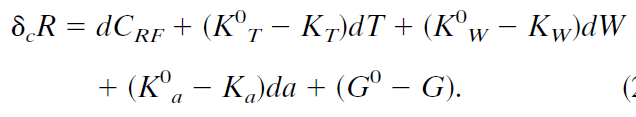

# SOM Equilibrium

In [17]:
#SOM CRE
F = som_net_asr_control - som_net_olr_control #control forcing all-sky
Fc = som_c_net_asr_control - som_c_net_olr_control #control forcing clearsky

#print(somc)

CRE = F-Fc #net CRE som Control

F_2xCO2 = som_net_asr_CO2 - som_net_olr_CO2 #control forcing all-sky
Fc_2xCO2 = som_c_net_asr_CO2 - som_c_net_olr_CO2 #control forcing clearsky

CRE_2xCO2 = F_2xCO2-Fc_2xCO2 #CRE after 2xCO2

DCRE = CRE_2xCO2 - CRE #change in CRE
DCRE_gm = globalMean(DCRE)

In [18]:
#T
#sets up change in global surface temperature for both cesm models
som_net_T_control = atm['som_control'].TREFHT.isel(time=slice(-(10*12+1),-1)).mean(dim='time')
som_net_T_CO2 = atm['som_2xCO2'].TREFHT.isel(time=slice(-(10*12+1),-1)).mean(dim='time')

cpl_net_T_control = atm['cpl_control'].TREFHT.isel(time=slice(-(10*12+1),-1)).mean(dim='time')
cpl_net_T_CO2 = atm['cpl_CO2ramp'].TREFHT.isel(time=slice(-(10*12+1),-1)).mean(dim='time')

#slab ocean model
DT = som_net_T_CO2 - som_net_T_control
DT_gm = float(globalMean(DT))

#coupled model
cpl_DT = cpl_net_T_CO2 - cpl_net_T_control
cpl_DT_gm = float(globalMean(cpl_DT))

### calculating lambdas

albedo

In [19]:
som_net_surf_sw_control = atm['som_control'].FSNS.isel(time=slice(-(10*12+1),-1)).mean(dim='time')
som_net_toa_sw_control = atm['som_control'].FSNT.isel(time=slice(-(10*12+1),-1)).mean(dim='time')

som_albedo_control = (som_net_toa_sw_control-som_net_surf_sw_control)/som_net_toa_sw_control

som_net_surf_sw_CO2 = atm['som_2xCO2'].FSNS.isel(time=slice(-(10*12+1),-1)).mean(dim='time')
som_net_toa_sw_CO2 = atm['som_2xCO2'].FSNT.isel(time=slice(-(10*12+1),-1)).mean(dim='time')

som_albedo_CO2 = (som_net_toa_sw_CO2-som_net_surf_sw_CO2)/som_net_toa_sw_CO2

#normalized change in albedo
dal = (som_albedo_CO2-som_albedo_control)
da=dal/(maskGlobalMean(dal,mw)/DT_gm)*.001 #shell et al (2008) multiplied albedo kernels by 0.001

#calculate lambda and reverse sign from direction of flux
l_a = -(i_a_sw)*da*100 #to cancel the 100(mb-1) wihtin the units
l_ac = -(i_a_sw_clr)*da*100


la = maskGlobalMean(l_a,mw)
lac = maskGlobalMean(l_ac,mw)
print(la)
print(lac)

a = lac-la
a2 = l_ac-l_a

print('a: ',a)

#plt.contourf(a2)
#plt.colorbar()

0.6797371669220075
0.8161184286174517
a:  0.13638126169544418


temperature

In [20]:
som_net_Tel_control = atm['som_control'].T.isel(time=slice(-(10*12+1),-1)).mean(dim='time')
som_net_Tel_CO2 = atm['som_2xCO2'].T.isel(time=slice(-(10*12+1),-1)).mean(dim='time')

#2d T array (lev,lat)
som_net_Tel_control_lev = np.average(som_net_Tel_control,axis=2)
som_net_Tel_CO2_lev = np.average(som_net_Tel_CO2,axis=2)

#2D T array (lat,lon)
som_net_Tel_control_surf = np.average(som_net_Tel_control,axis=0,weights=lw)
som_net_Tel_CO2_surf = np.average(som_net_Tel_CO2,axis=0, weights = lw)

dtl=(som_net_Tel_CO2_lev-som_net_Tel_control_lev)
dts=(som_net_Tel_CO2_surf-som_net_Tel_control_surf)
DT_lev = dtl/(globalMeanInterp(dtl,mw,lw)/DT_gm*26) #26 represents the number of layers and turns the average to a sum
DT_surf = dts/(maskGlobalMean(dts,mw)/DT_gm*26)

#(lev,lat)
l_pc = DT_lev*(plat_p_lw_clr)*100
l_p = DT_lev*(plat_p_lw)*100

#(lat,lon)
l_pc_surf = DT_surf*(plon_p_lw_clr)*100
l_p_surf = DT_surf*(plon_p_lw)*100

lp = -globalMeanInterp(l_p,mw,lw)
lpc = -globalMeanInterp(l_pc,mw,lw)

lp2 = -maskGlobalMean(l_p_surf,mw)
lpc2 = -maskGlobalMean(l_pc_surf,mw)

print(lpc)
print(lp)
print(lpc2)
print(lp2)

p = lpc-lp
p2 = l_pc_surf-l_p_surf

print("p: ",p)

#plt.contourf(l_pc_surf)
#plt.colorbar()

-2.83548097773893
-3.5200174176490964
-2.8534673079436366
-3.137876671143609
p:  0.6845364399101665


water vapor

In [21]:
som_q_control = atm['som_control'].Q.isel(time=slice(-(10*12+1),-1)).mean(dim='time')

ave_som_q_control = np.average(som_q_control,axis=2) #(lev,lat)
lev_ave_som_q_control = np.average(som_q_control,axis=0,weights=lw) #(lat,lon)

som_q_CO2 = atm['som_2xCO2'].Q.isel(time=slice(-(10*12+1),-1)).mean(dim='time')

ave_som_q_CO2 = np.average(som_q_CO2,axis=2) 
lev_ave_som_q_CO2 = np.average(som_q_CO2,axis=0,weights=lw) 

dq=(np.log(ave_som_q_CO2)-np.log(ave_som_q_control))
dqs=(np.log(lev_ave_som_q_CO2)-np.log(lev_ave_som_q_control))
dq_lev=dq/(globalMeanInterp(dq,mw,lw)/DT_gm*26)
dq_surf=dqs/(maskGlobalMean(dqs,mw)/DT_gm*26)

##specific humidity
l_q_sw = dq_lev*(plat_wv_sw)*100
l_qc_sw = dq_lev*(plat_wv_sw_clr)*100
l_q_lw = dq_lev*(plat_wv_lw)*100
l_qc_lw = dq_lev*(plat_wv_lw_clr)*100

print("l_q_sw: ",globalMeanInterp(l_q_sw,mw,lw))
print("l_qc_sw: ",globalMeanInterp(l_qc_sw,mw,lw))
print("l_q_lw: ",globalMeanInterp(l_q_lw,mw,lw))
print("l_qc_lw: ",globalMeanInterp(l_qc_lw,mw,lw))

ml_qc_sw = globalMeanInterp(l_qc_sw,mw,lw)
ml_q_sw = globalMeanInterp(l_q_sw,mw,lw)
ml_qc_lw = globalMeanInterp(l_qc_lw,mw,lw)
ml_q_lw = globalMeanInterp(l_q_lw,mw,lw)

qlw = (ml_qc_lw-ml_q_lw)
qsw = (ml_qc_sw-ml_q_sw)

q = -qlw + qsw

print("q: ",q)

l_q_sw_surf = dq_surf*(plon_wv_sw)*100
l_qc_sw_surf = dq_surf*(plon_wv_sw_clr)*100
l_q_lw_surf = dq_surf*(plon_wv_lw)*100
l_qc_lw_surf = dq_surf*(plon_wv_lw_clr)*100

qlw2 = (l_qc_lw_surf-l_q_lw_surf)
qsw2 = (l_qc_sw_surf-l_q_sw_surf)

q2 = -qlw2 + qsw2
#plt.contourf(q2)
#plt.colorbar()

ave_qlw2 = maskGlobalMean(l_q_lw_surf,mw)
print(ave_qlw2)


l_q_sw:  0.1694527580409344
l_qc_sw:  0.10863929559622235
l_q_lw:  -1.4022006111339171
l_qc_lw:  -1.8280813781361862
q:  0.365067304557557
-1.0067457177410133


term1:  <xarray.DataArray ()>
array(-0.276658)
term2:  0.13638126169544418
term3:  0.6845364399101665
term4:  0.365067304557557
l_c:  <xarray.DataArray ()>
array(0.636564)


/kt11/ktyle/anaconda3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)



term1:  <xarray.DataArray ()>
array(-0.347721)
term2:  0.13638126169544423
term3:  -0.28440936319997245
term4:  0.32994124956770376
l_c2:  -0.3678156690870324


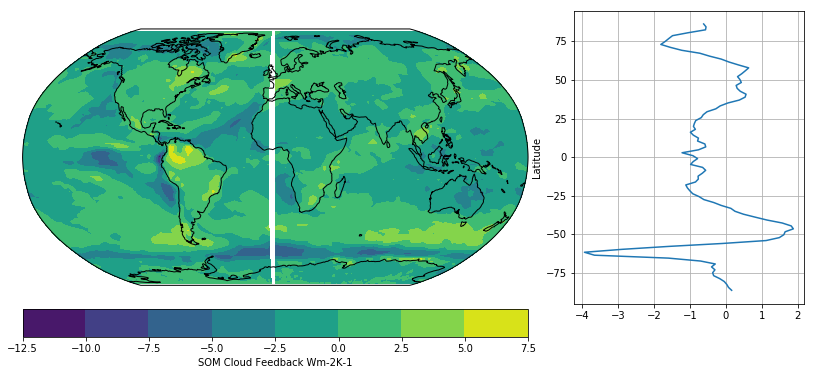

In [22]:
#mean of the global mean values
print('term1: ',DCRE_gm/DT_gm)
print('term2: ',a)
print('term3: ',p)
print('term4: ',q)

l_c = (DCRE_gm/DT_gm) - a + p + q
print('l_c: ',l_c)

#global mean of the feedback values
l_c2 = (DCRE/DT_gm) - a2 + p2 + q2

make_map(l_c2,"SOM Cloud Feedback Wm-2K-1")
print()
print('term1: ',globalMean(DCRE/DT,mw))
print('term2: ',maskGlobalMean(a2,mw))
print('term3: ',maskGlobalMean(p2,mw))
print('term4: ',maskGlobalMean(q2,mw))
print('l_c2: ',maskGlobalMean(l_c2,mw))

CRE CPL

In [23]:
#CRE cpl
cpl_F = cpl_net_asr_control - cpl_net_olr_control #forcing all-sky
cpl_Fc = cpl_c_net_asr_control - cpl_c_net_olr_control #forcing clearsky

cpl_CRE = cpl_F-cpl_Fc #net CRE som Control

cpl_F_2xCO2 = cpl_net_asr_CO2 - cpl_net_olr_CO2
cpl_Fc_2xCO2 = cpl_c_net_asr_CO2 - cpl_c_net_olr_CO2

cpl_CRE_2xCO2 = cpl_F_2xCO2-cpl_Fc_2xCO2 #CRE after 2xCO2

cpl_DCRE = cpl_CRE_2xCO2 - cpl_CRE
cpl_DCRE_gm = globalMean(cpl_DCRE)

cpl_DFc = cpl_Fc_2xCO2 - cpl_Fc
cpl_DF = cpl_F_2xCO2 - cpl_F

cpl_DFc_gm = float(globalMean(cpl_DFc))
cpl_DF_gm = float(globalMean(cpl_DF))

In [24]:
#T
cpl_net_T_control = atm['cpl_control'].TREFHT.isel(time=slice(-(20*12+1),-1)).mean(dim='time')
cpl_net_T_CO2 = atm['cpl_CO2ramp'].TREFHT.isel(time=slice(-(20*12+1),-1)).mean(dim='time')

#DT = cpl_net_T_CO2 - cpl_net_T_control
#DT_gm = float(globalMean(DT))

CPL Albedo

In [25]:
cpl_net_surf_sw_control = atm['cpl_control'].FSNS.isel(time=slice(-(20*12+1),-1)).mean(dim='time')
cpl_net_toa_sw_control = atm['cpl_control'].FSNT.isel(time=slice(-(20*12+1),-1)).mean(dim='time')

cplw = np.cos(np.deg2rad(cpl_net_surf_sw_control.lat))

cpl_albedo_control = (cpl_net_toa_sw_control-cpl_net_surf_sw_control)/cpl_net_toa_sw_control

cpl_net_surf_sw_CO2 = atm['cpl_CO2ramp'].FSNS.isel(time=slice(-(20*12+1),-1)).mean(dim='time')
cpl_net_toa_sw_CO2 = atm['cpl_CO2ramp'].FSNT.isel(time=slice(-(20*12+1),-1)).mean(dim='time')

cpl_albedo_CO2 = (cpl_net_toa_sw_CO2-cpl_net_surf_sw_CO2)/cpl_net_toa_sw_CO2

dal = (cpl_albedo_CO2-cpl_albedo_control)
da=dal/(maskGlobalMean(dal,mw)/DT_gm)*.001

cpl_l_a = -(i_a_sw)*da*100
cpl_l_ac = -(i_a_sw_clr)*da*100

cpl_la = maskGlobalMean(cpl_l_a,cplw)
cpl_lac = maskGlobalMean(cpl_l_ac,cplw)
print(cpl_la)
print(cpl_lac)

cpl_a = cpl_lac-cpl_la

print("a: ",cpl_a)

cpl_a2 = cpl_l_ac-cpl_l_a

#plt.contourf(cpl_a2)
#plt.colorbar()

0.5972038478717075
0.7792855452527436
a:  0.18208169738103608


CPL T

In [26]:
cpl_net_Tel_control = atm['cpl_control'].T.isel(time=slice(-(20*12+1),-1)).mean(dim='time')
cpl_net_Tel_CO2 = atm['cpl_CO2ramp'].T.isel(time=slice(-(20*12+1),-1)).mean(dim='time')

#averaging (lev,lat)
cpl_net_Tel_control_lev = np.average(cpl_net_Tel_control,axis=2)
cpl_net_Tel_CO2_lev = np.average(cpl_net_Tel_CO2,axis=2)

cpl_net_Tel_control_surf = np.average(cpl_net_Tel_control,axis=0,weights=lw)
cpl_net_Tel_CO2_surf = np.average(cpl_net_Tel_CO2,axis=0,weights=lw)

dtl=(cpl_net_Tel_CO2_lev-cpl_net_Tel_control_lev)
dts=(cpl_net_Tel_CO2_surf-cpl_net_Tel_control_surf)
cpl_DT_lev = dtl/(globalMeanInterp(dtl,mw,lw)/cpl_DT_gm*26)
cpl_DT_surf = dts/(maskGlobalMean(dts,mw)/cpl_DT_gm*26)

cpl_l_pc = cpl_DT_lev*(plat_p_lw_clr)*100
cpl_l_p = cpl_DT_lev*(plat_p_lw)*100

cpl_lp = -globalMeanInterp(cpl_l_p,mw,lw)
cpl_lpc = -globalMeanInterp(cpl_l_pc,mw,lw)

print(cpl_lp)
print(cpl_lpc)

cpl_p = cpl_lpc-cpl_lp

print("p: ",cpl_p)

cpl_l_pc2 = cpl_DT_surf*(plon_p_lw_clr)*100
cpl_l_p2 = cpl_DT_surf*(plon_p_lw)*100

cpl_p2 = cpl_l_pc2-cpl_l_p2

#plt.contourf(cpl_p2)
#plt.colorbar()

-2.4677979337571676
-1.937743262455207
p:  0.5300546713019607


CPL WV

In [27]:
cpl_q_control = atm['cpl_control'].Q.isel(time=slice(-(20*12+1),-1)).mean(dim='time')

ave_cpl_q_control = np.average(cpl_q_control,axis=2) 
surf_ave_cpl_q_control = np.average(cpl_q_control,axis=0,weights=lw) 

cpl_q_CO2 = atm['cpl_CO2ramp'].Q.isel(time=slice(-(20*12+1),-1)).mean(dim='time')

ave_cpl_q_CO2 = np.average(cpl_q_CO2,axis=2) 
surf_ave_cpl_q_CO2 = np.average(cpl_q_CO2,axis=0,weights=lw) 

dq=(np.log(ave_cpl_q_CO2)-np.log(ave_cpl_q_control))
dqs=(np.log(surf_ave_cpl_q_CO2)-np.log(surf_ave_cpl_q_control))
dq_lev=dq/(globalMeanInterp(dq,mw,lw)/cpl_DT_gm*26)
dq2=dqs/(maskGlobalMean(dqs,mw)/cpl_DT_gm*26)

l_q_sw = dq*(plat_wv_sw)*100
l_qc_sw = dq*(plat_wv_sw_clr)*100
l_q_lw = dq*(plat_wv_lw)*100
l_qc_lw = dq*(plat_wv_lw_clr)*100
w = np.cos(np.deg2rad(mlat))

print("l_q_sw: ",globalMeanInterp(l_q_sw,w,lw))
print("l_qc_sw: ",globalMeanInterp(l_qc_sw,w,lw))
print("l_q_lw: ",globalMeanInterp(l_q_lw,w,lw))
print("l_qc_lw: ",globalMeanInterp(l_qc_lw,w,lw))

ml_qc_sw = globalMeanInterp(l_qc_sw,mw,lw)
ml_q_sw = globalMeanInterp(l_q_sw,mw,lw)
ml_qc_lw = globalMeanInterp(l_qc_lw,mw,lw)
ml_q_lw = globalMeanInterp(l_q_lw,mw,lw)

cpl_qlw = ml_qc_lw-ml_q_lw
cpl_qsw = ml_qc_sw-ml_q_sw

cpl_q = -cpl_qlw + cpl_qsw

print("q: ",cpl_q)

l_q_sw = dq2*(plon_wv_sw)*100
l_qc_sw = dq2*(plon_wv_sw_clr)*100
l_q_lw = dq2*(plon_wv_lw)*100
l_qc_lw = dq2*(plon_wv_lw_clr)*100

cpl_qlw2 = l_qc_lw-l_q_lw
cpl_qsw2 = l_qc_sw-l_q_sw

cpl_q2 = -cpl_qlw2+cpl_qsw2

#plt.contourf(cpl_q2)
#plt.colorbar()

print('q2: ',maskGlobalMean(cpl_q2,mw))

l_q_sw:  0.22550065668596797
l_qc_sw:  0.13709226180797568
l_q_lw:  -2.0562126244099157
l_qc_lw:  -2.6662173695378524
q:  0.5215963502499443
q2:  0.21968959682179742


term1:  <xarray.DataArray ()>
array(-0.512667)
term2:  0.18208169738103608
term3:  0.5300546713019607
term4:  0.5215963502499443
l_c:  <xarray.DataArray ()>
array(0.356902)



/kt11/ktyle/anaconda3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


term1:  <xarray.DataArray ()>
array(-0.512741)
term2:  0.18208169738103613
term3:  -0.14246332972355033
term4:  0.21968959682179742
l_c2:  -0.619197306627488


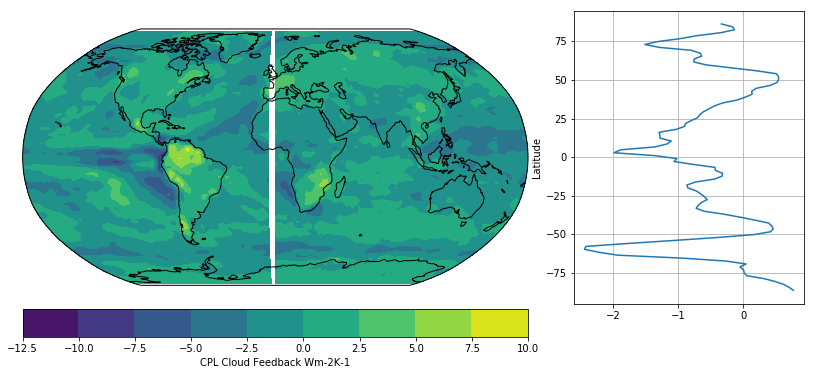

In [28]:
#mean of the global mean values
print('term1: ',cpl_DCRE_gm/cpl_DT_gm)
print('term2: ',cpl_a)
print('term3: ',cpl_p)
print('term4: ',cpl_q)

cpl_l_c = (cpl_DCRE_gm/cpl_DT_gm) - cpl_a + cpl_p + cpl_q
print('l_c: ',cpl_l_c)

#global mean of the feedback values
cpl_l_c2 = (cpl_DCRE/cpl_DT_gm) - cpl_a2 + cpl_p2 + cpl_q2
print()
make_map(cpl_l_c2,"CPL Cloud Feedback Wm-2K-1")
print('term1: ',globalMean(cpl_DCRE/cpl_DT_gm,mw))
print('term2: ',maskGlobalMean(cpl_a2,mw))
print('term3: ',maskGlobalMean(cpl_p2,mw))
print('term4: ',maskGlobalMean(cpl_q2,mw))
print('l_c2: ',maskGlobalMean(cpl_l_c2,mw))